<a href="https://colab.research.google.com/github/phuongnt3391/Timeseries/blob/main/ARMA_and_ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('us_airline_carrier_passenger.csv')

In [ ]:
!pip3 install --upgrade statsmodels

Non seasonal ARIMA models:
ARMA(p,q)
ARIMA(p,d,q)

In [ ]:
import statsmodels

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA

Split data into training and test set

    Training: up until 2016-12-01
    Test: from 2017-01-01 until 2019-12-01



In [ ]:
df.dtypes

month         object
passengers     int64
dtype: object

In [ ]:
df['month'] = pd.to_datetime(df['month'])

In [ ]:
import datetime
df_train = df[df['month'] <= datetime.datetime.strptime('2016-12-01','%Y-%m-%d')] 
df_test = df[df['month'] > datetime.datetime.strptime('2016-12-01','%Y-%m-%d')] 

In [ ]:
df_train.tail()

,month,passengers
199,2016-08-01,73450
200,2016-09-01,66477
201,2016-10-01,69539
202,2016-11-01,66591
203,2016-12-01,67983


In [ ]:
df_test.head()

,month,passengers
204,2017-01-01,62621
205,2017-02-01,58377
206,2017-03-01,72962
207,2017-04-01,70262
208,2017-05-01,73679


In [ ]:
df_train= df_train.set_index('month')
df_test=df_test.set_index('month')


In [ ]:
df_train.tail()

,month,passengers
199,2016-08-01,73450
200,2016-09-01,66477
201,2016-10-01,69539
202,2016-11-01,66591
203,2016-12-01,67983


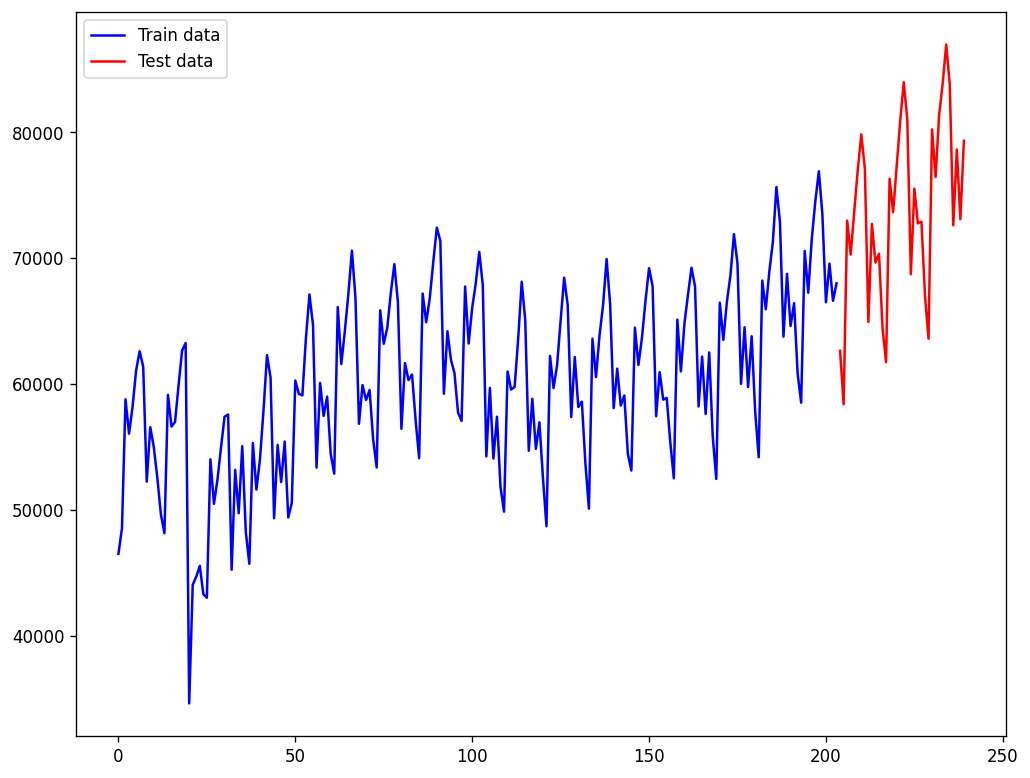

In [ ]:

# Visualize the data
plt.figure(figsize =(10,8),dpi=120)
# Training and testing data
plt.plot(df_train['passengers'],'b')
plt.plot(df_test['passengers'],'r')
plt.legend(['Train data','Test data'])

# Step 1: Augmented Dickey Fuller unit root test for stationary
* Significant level: 5%
* p-value = 0.025

Null hypothesis H0: The data is not stationary ~ p-value >= 0.025 
Alternative hypothesis H1: The data is stationary~ p-value < 0.025 (Critical region)

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(df_train)

(-0.9529124941948434,
 0.7700488660390645,
 13,
 190,
 {'1%': -3.4652439354133255,
  '10%': -2.574944653739612,
  '5%': -2.8768752281673717},
 3449.617955746232)

p-values =  0.77 > 0.025
We have weak evidence to reject null hypothesis, the data is NON stationary



# Step2: 
We need to make the data stationary by using diff



In [ ]:
stationary_df_train = df_train.diff()
stationary_df_train.dropna(inplace=True)

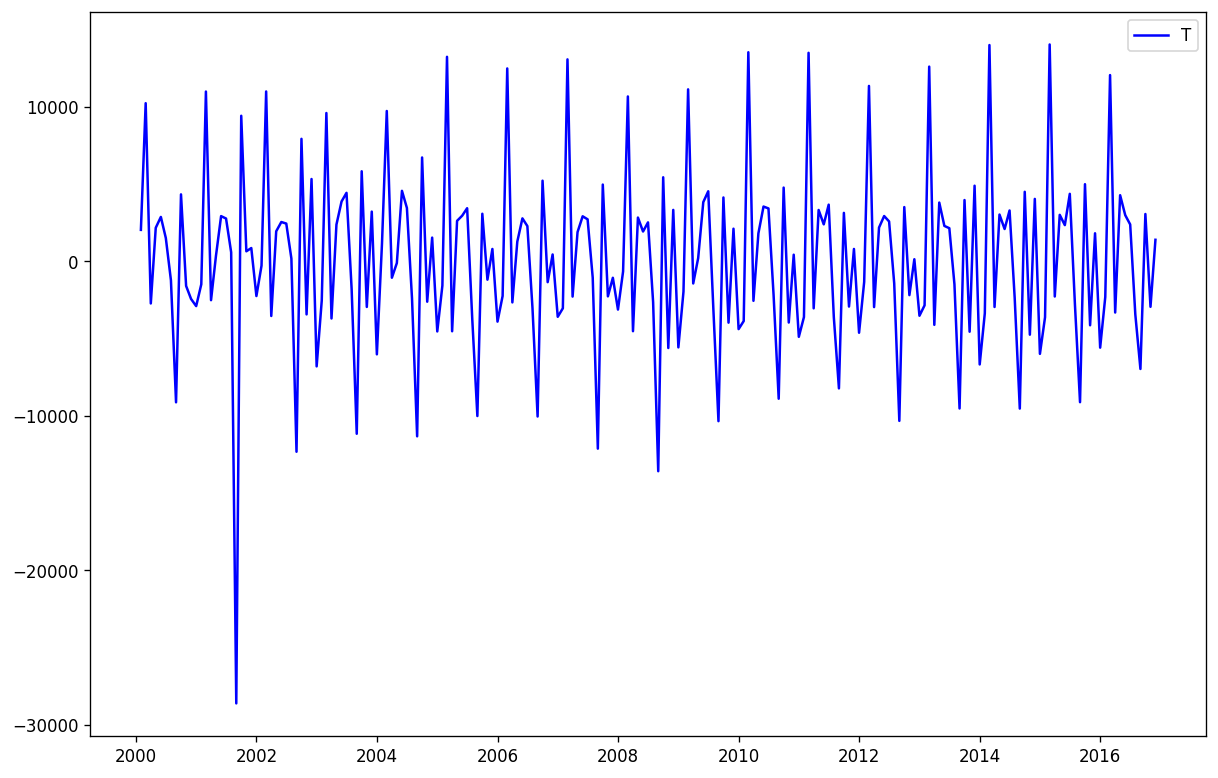

In [ ]:

# Visualize the data
plt.figure(figsize =(12,8),dpi=120)
# Training and testing data
plt.plot(stationary_df_train['passengers'],'b')
plt.legend('Train data')

Test stationary of data after shifting

In [ ]:
adfuller(stationary_df_train)

(-3.770003898122402,
 0.0032295638943137133,
 12,
 190,
 {'1%': -3.4652439354133255,
  '10%': -2.574944653739612,
  '5%': -2.8768752281673717},
 3430.804868488187)

p-values =  0.0032< 0.025; which falls in the critical region
* We have strong evidence to reject null hypothesis, the data is Stationary

# Step3: Find the p,q
* p: AR order(using pacf)
* q: Moving average order (using acf)

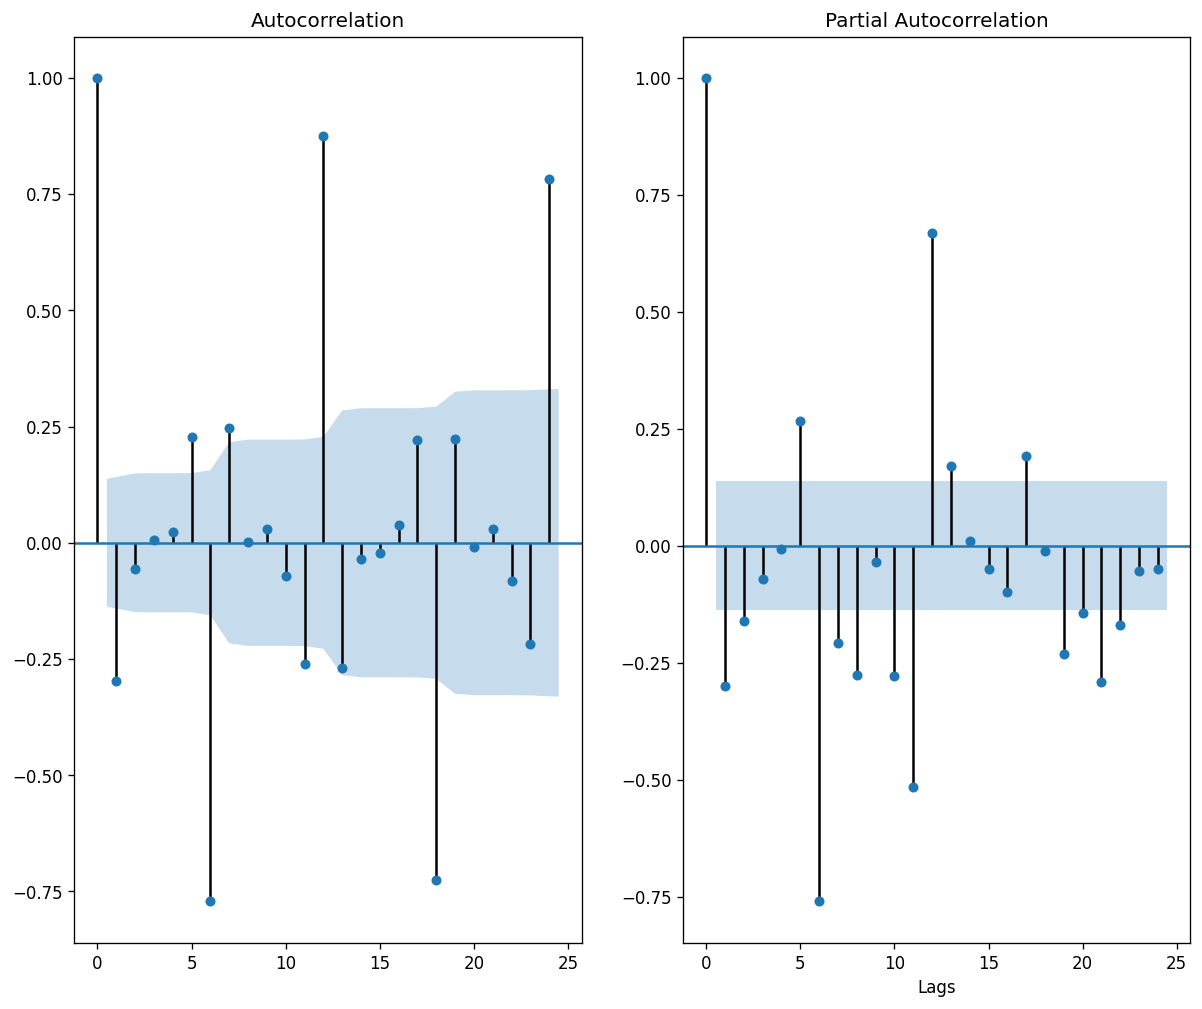

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,10),dpi=120)
res1 = plot_acf(stationary_df_train['passengers'],ax[0])
res2 = plot_pacf(stationary_df_train['passengers'],ax[1])
plt.xlabel('Lags')
plt.show()

Choose p=6, q=6

#Step4: Train ARMA model

In [ ]:
p,q=(6,6)

In [ ]:
model_arma = ARMA(stationary_df_train,order=(p,q)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

#Evaluate the model

In [ ]:
model_arma.aic #error

3782.022314233962

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
fitted_values = model_arma.fittedvalues

In [ ]:
MSE = mean_squared_error(stationary_df_train,fitted_values)
MSE

8059227.968474685

In [ ]:
RMSE = np.sqrt(MSE)
RMSE

2838.877941806355

Data Visualization

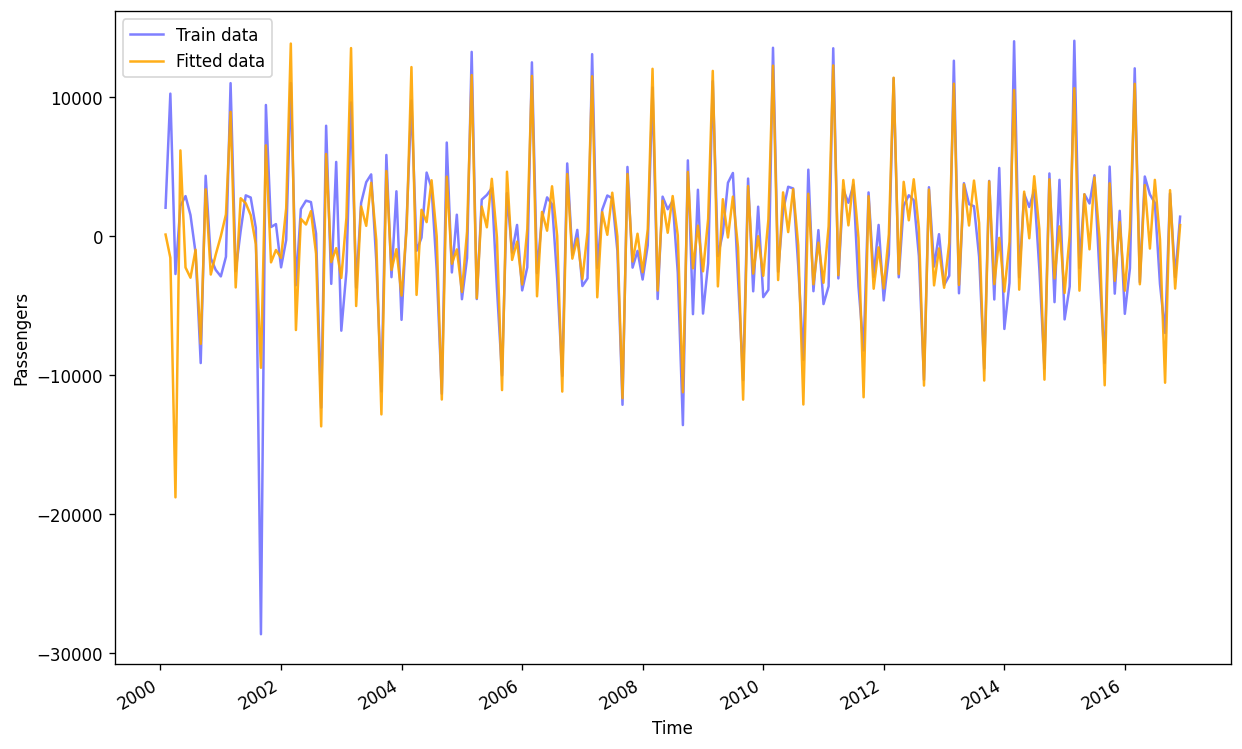

In [ ]:
plt.figure(figsize =(12,8),dpi=120)
plt.plot(stationary_df_train['passengers'],color='blue',alpha=0.5)
fitted_values.plot(kind='line',color='orange',alpha=0.9)
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(['Train data','Fitted data'])

As from the above plot, we can say that it is a pretty good fit

#Predict the  data

In [ ]:
start_date = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.datetime.strptime('2019-12-01','%Y-%m-%d')

In [81]:
predictions= model_arma.predict(start=start_date,end=end_date)

Must convert forecasted_values from Stationary to Non-stationary data

In [80]:
initial_values = df_train.iloc[-1].values
initial_values

array([67983])

In [82]:
Forecasted_values = initial_values + predictions.cumsum()

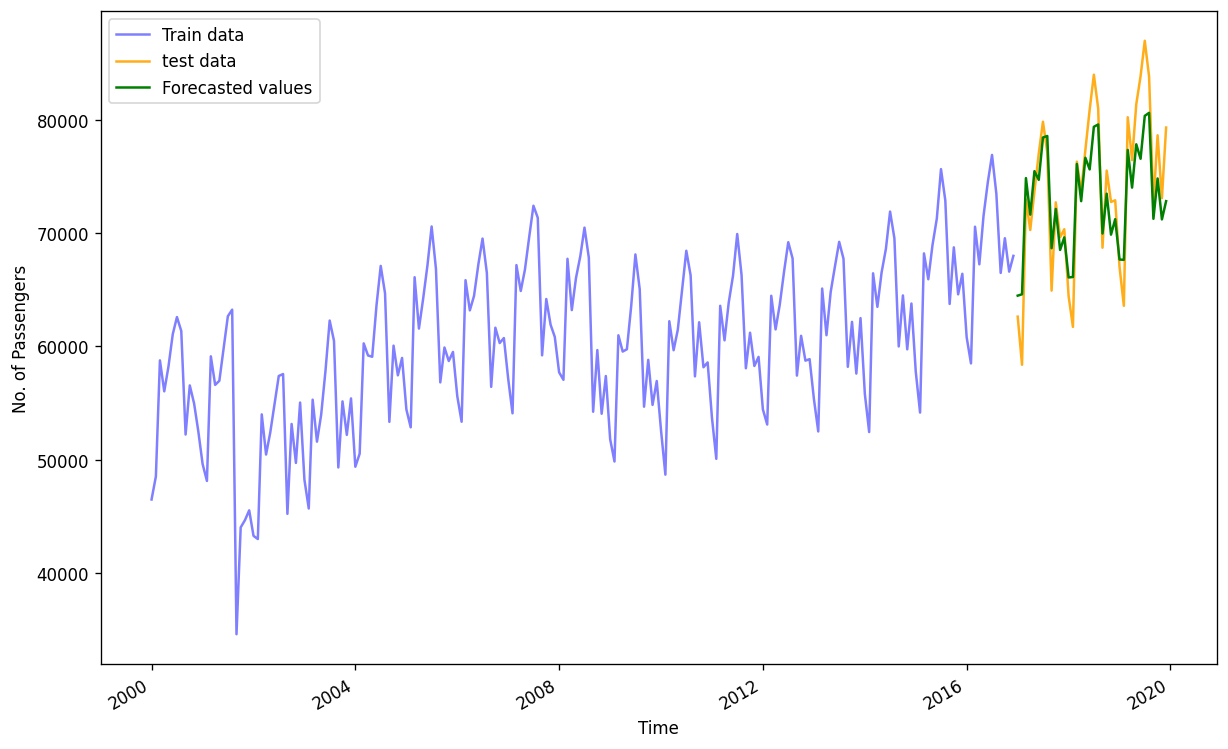

In [89]:
plt.figure(figsize =(12,8),dpi=120)
plt.plot(df_train,color='blue',alpha=0.5)
plt.plot(df_test,color='orange',alpha=0.9)
Forecasted_values.plot(kind='line',color='green')
plt.xlabel('Time')
plt.ylabel('No. of Passengers')
plt.legend(['Train data','test data','Forecasted values'])

We got the model which has a really good fit

## ARIMA Model (p,d,q)
Differs from ARMA model in d: no. of non seasonal differences used to make time series stationary.
We can use the same p,q from ARMA model p,q = (6,6)
Try with:  p,d,q=(6,0,6)

In [90]:
model_arima = ARIMA(stationary_df_train,order=(6,0,6)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [91]:
fitted_ARIMA = model_arima.fittedvalues

In [92]:
start_date = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.datetime.strptime('2019-12-01','%Y-%m-%d')

In [94]:
predicted_ARIMA= model_arma.predict(start=start_date,end=end_date) #Stationary data

Convert predicted values from being stationary to Non-stationary

In [95]:
Forecasted_ARIMA = 67983 + predicted_ARIMA.cumsum()

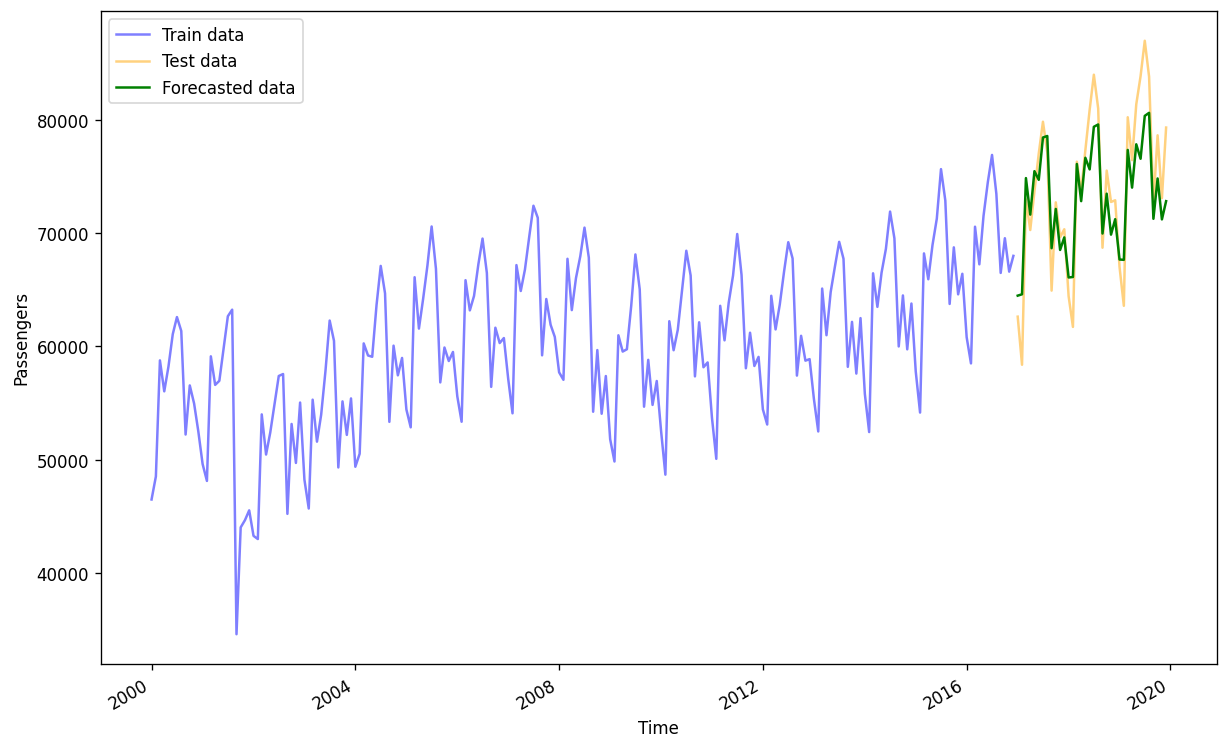

In [106]:
plt.figure(figsize =(12,8),dpi=120)
plt.plot(df_train['passengers'],color='blue',alpha=0.5)
plt.plot(df_test['passengers'],color='orange',alpha=0.5)
Forecasted_ARIMA.plot(kind='line',color='green')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(['Train data','Test data','Forecasted data'])

## Auto ARIMA

In [98]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [99]:
from pmdarima import auto_arima

In [100]:
model_autoARIMA = auto_arima(stationary_df_train,start_p=12, d=0, start_q=6, 
                          max_p=24, max_d=5, max_q=24, seasonal=False,stationary=True, trace=True,scoring='mse')

Performing stepwise search to minimize aic
 ARIMA(12,0,6)(0,0,0)[0] intercept   : AIC=3758.330, Time=2.86 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4100.940, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4084.137, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4078.462, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4099.007, Time=0.01 sec
 ARIMA(11,0,6)(0,0,0)[0] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(12,0,5)(0,0,0)[0] intercept   : AIC=3765.293, Time=2.64 sec
 ARIMA(13,0,6)(0,0,0)[0] intercept   : AIC=3759.911, Time=3.29 sec
 ARIMA(12,0,7)(0,0,0)[0] intercept   : AIC=3750.845, Time=3.26 sec
 ARIMA(11,0,7)(0,0,0)[0] intercept   : AIC=3739.212, Time=3.16 sec
 ARIMA(10,0,7)(0,0,0)[0] intercept   : AIC=3754.210, Time=2.61 sec
 ARIMA(11,0,8)(0,0,0)[0] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(10,0,6)(0,0,0)[0] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(10,0,8)(0,0,0)[0] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(12,0,8)(0,0,0)[0] intercept   : AIC=

In [101]:
model_autoARIMA = ARIMA(stationary_df_train,order=(11,0,7)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [102]:
start_date = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.datetime.strptime('2019-12-01','%Y-%m-%d')

In [103]:
predicted_autoARIMA= model_autoARIMA.predict(start=start_date,end=end_date) #Stationary data

In [104]:
initial_values = df_train.iloc[-1].values
initial_values

array([67983])

In [105]:
# Turn predicted_autoARIMA from being stationary to Non stationary
Forecasted_autoARIMA = initial_values + predicted_autoARIMA.cumsum()

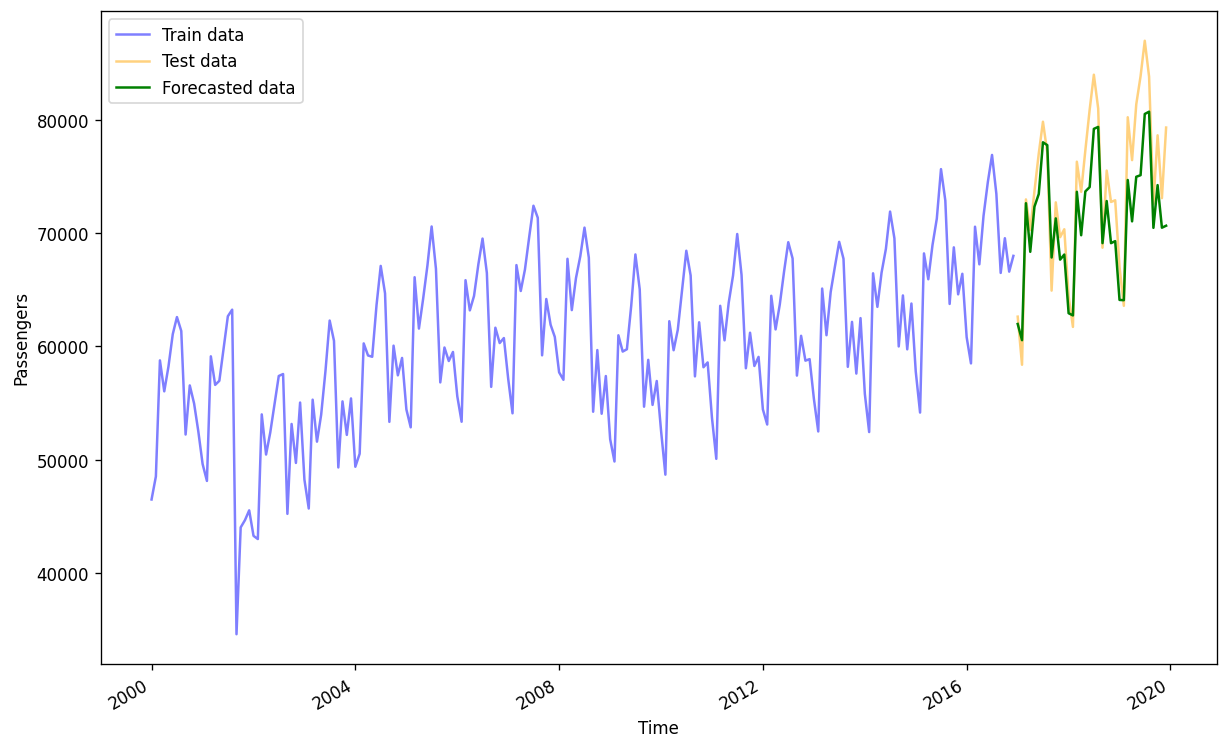

In [107]:
# Visualize data
plt.figure(figsize =(12,8),dpi=120)
plt.plot(df_train['passengers'],color='blue',alpha=0.5)
plt.plot(df_test['passengers'],color='orange',alpha=0.5)
Forecasted_autoARIMA.plot(kind='line',color='green')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(['Train data','Test data','Forecasted data'])